In [1]:
!wget -O model_a.h5 https://github.com/andrefakhoury/chess-board-recognition/raw/main/model/model_a.h5

--2021-07-14 23:24:56--  https://github.com/andrefakhoury/chess-board-recognition/raw/main/model/model_a.h5
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/andrefakhoury/chess-board-recognition/main/model/model_a.h5 [following]
--2021-07-14 23:24:56--  https://raw.githubusercontent.com/andrefakhoury/chess-board-recognition/main/model/model_a.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12640376 (12M) [application/octet-stream]
Saving to: ‘model_a.h5’

model_a.h5          100%[===================>]  12.05M  23.0MB/s    in 0.5s    

2021-07-14 23:24:57 (23.0 MB/s) - ‘model_a.h5’ saved [12640

In [2]:
!wget -O model_b.h5 https://github.com/andrefakhoury/chess-board-recognition/raw/main/model/model_b.h5

--2021-07-14 23:24:57--  https://github.com/andrefakhoury/chess-board-recognition/raw/main/model/model_b.h5
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/andrefakhoury/chess-board-recognition/main/model/model_b.h5 [following]
--2021-07-14 23:24:57--  https://raw.githubusercontent.com/andrefakhoury/chess-board-recognition/main/model/model_b.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12654320 (12M) [application/octet-stream]
Saving to: ‘model_b.h5’

model_b.h5          100%[===================>]  12.07M  67.4MB/s    in 0.2s    

2021-07-14 23:24:57 (67.4 MB/s) - ‘model_b.h5’ saved [12654

In [1]:
IMAGE = 'chessboard.jpg'

In [2]:
INPUT_SIZE = 512
LOAD = [('model_a.h5', 0.5), ('model_b.h5', 1.0)]

In [3]:
import os
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# returns the angle between two vectors ab and ac
def get_angle(ab, ac):
    x = np.clip((ab @ ac) / np.linalg.norm(ab) / np.linalg.norm(ac), -1, 1)
    return np.degrees(np.arccos(x)) if not np.isnan(x) else 0

# check if the set of points form a square
def check_square(points):
    if len(points) != 4:
        return 4 * 90 ** 2, 0
    a, b, c, d = np.squeeze(points)
    bcd = get_angle(b - c, d - c)
    cda = get_angle(c - d, a - d)
    dab = get_angle(d - a, b - a)
    abc = get_angle(a - b, c - b)

    return np.sum((np.array([bcd, cda, dab, abc]) - 90) ** 2), np.mean(np.abs([a - b, b - c, c - d, d - a]))

# count how many squares are inside the square of index i
def child_count(i, hierarchy, is_square):
    j = hierarchy[0, i, 2]
    if j < 0:
        return 0

    total = 0
    while hierarchy[0, j, 0] > 0:
        j = hierarchy[0, j, 0]
    while j > 0:
        if is_square[j]:
            total += 1# + child_count(j, hierarchy, is_square)
        j = hierarchy[0, j, 1]
    return total

In [13]:
def get_contours(image, blur_radius):
    edge_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edge_image = cv2.GaussianBlur(edge_image, (blur_radius, blur_radius), 2)
    edge_image = cv2.Canny(edge_image, 50, 150)

    # Compatibility fix for OpenCV 3.x and 4.x
    contours_info = cv2.findContours(edge_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = list(contours_info[-2])  # Convert to a list to ensure mutability
    hierarchy = contours_info[-1]  # This may be None if no contours are found

    if not contours:
        raise ValueError("No contours found. Check if the image is loaded correctly and preprocessed.")

    # Approximate contours
    for i in range(len(contours)):
        contours[i] = cv2.approxPolyDP(contours[i], 0.04 * cv2.arcLength(contours[i], True), True)

    return contours, hierarchy



def get_candidate_boards(contours, hierarchy, max_error, min_side, min_child):
    square_info = list(map(lambda contour: check_square(contour), contours))
    is_square = list(map(lambda info: info[0] < max_error and info[1] > min_side, square_info))

    squares = []
    for i, square_flag, (error, side), contour in zip(range(len(contours)), is_square, square_info, contours):
        if square_flag:
            cnt = child_count(i, hierarchy, is_square)
            if cnt > min_child:
                squares.append(contour)

    return squares

def preprocess(image):
    image2 = np.copy(image)
    all_boards = []

    for blur in (3, 5, 7, 9, 11):
        contours, hierarchy = get_contours(image, blur)
        boards = get_candidate_boards(contours, hierarchy, 4 * 10 ** 2, 10, 10)
        all_boards.extend(boards)
        for board in boards:
            error, side = check_square(board)
    all_boards = list(map(lambda board: (board, check_square(board)[1]), all_boards))
    all_boards = sorted(all_boards, key=lambda board_side: board_side[1], reverse=True)
    best_board = (None, 0)
    for board, side in all_boards:
      if side >= best_board[1] * 0.9:
        best_board = (board, side)

    return best_board[0]

In [11]:
# rotate and crop the image, given the points of the new border
def crop_image(image, points, rotate=False):
    points = np.squeeze(points)
    if rotate:
      low, high = points[np.lexsort((points[:, 1], points[:, 0]))[:2]]
      angle = -get_angle(np.array([0, 1]), high - low)
      if angle < -90:
          angle, low, high = angle + 180, high, low
    
      rot = cv2.getRotationMatrix2D((int(low[0]), int(low[1])), angle, 1.0)
      h, w = image.shape[:2]
      image = cv2.warpAffine(image, rot, (w, h))
      points = np.concatenate((points, np.ones(points.shape[0]).reshape((-1, 1))), axis=1)
      points = (rot @ points.T).T.astype(np.int32)
    
    image = image[points[:, 1].min():points[:, 1].max(), points[:, 0].min():points[:, 0].max()]
    return image

/tmp/ipykernel_25428/2917492917.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(IMAGE)


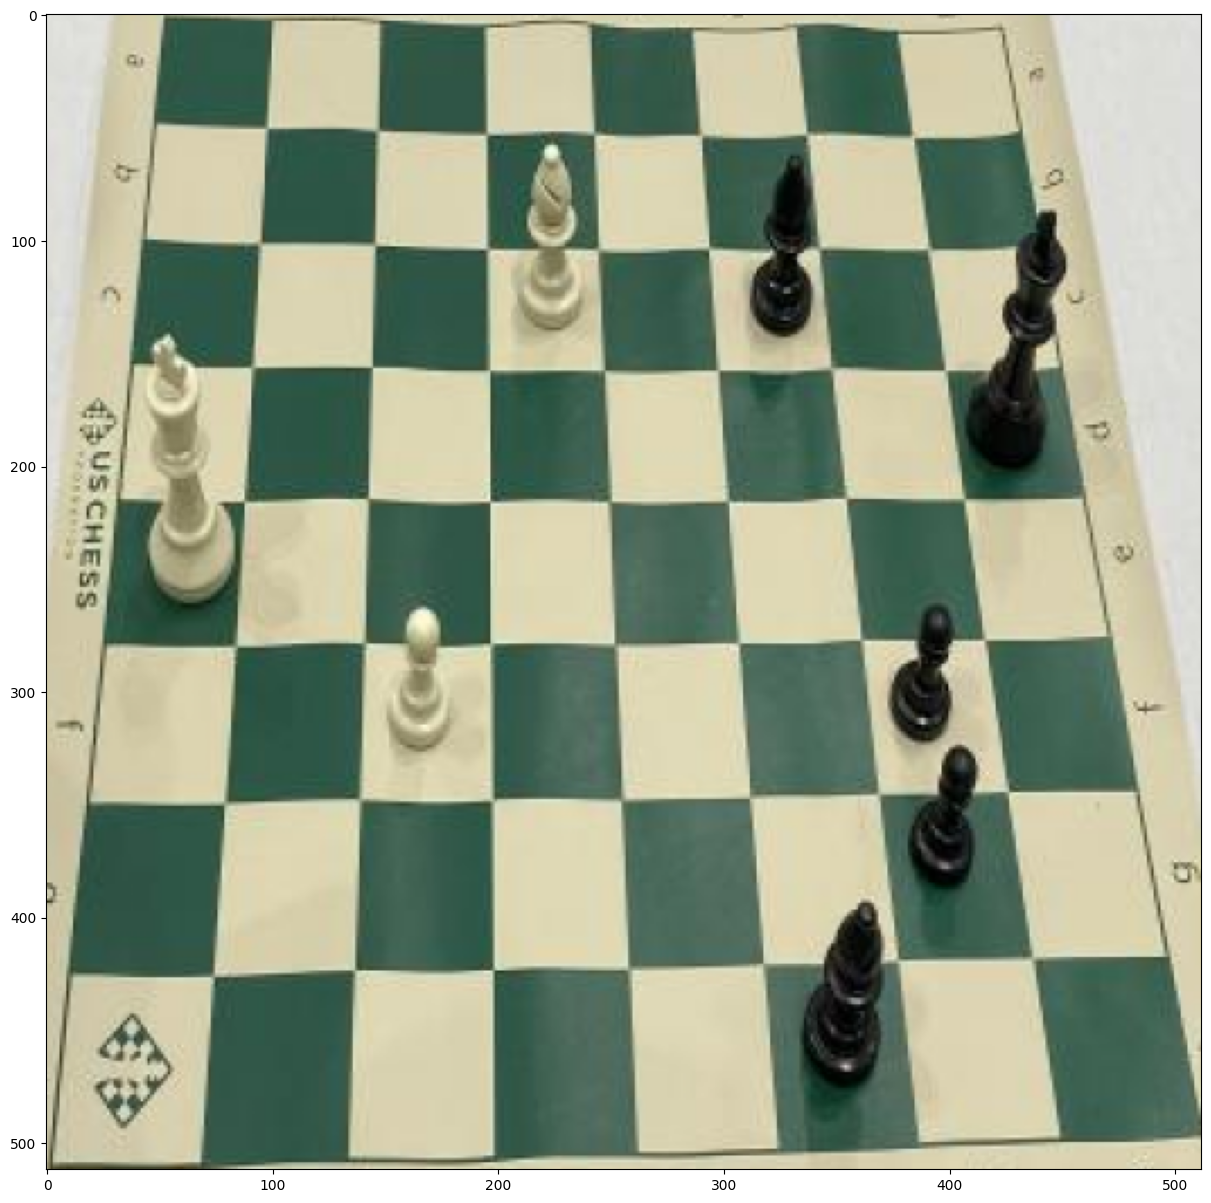

In [14]:
# read and resize the image
image = imageio.imread(IMAGE)
board = preprocess(image)
cropped = crop_image(image, board)
cropped = cv2.resize(cropped, (INPUT_SIZE, INPUT_SIZE), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(15, 15))
plt.imshow(cropped)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2025-02-20 00:15:37.182258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739990737.203262   25428 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739990737.209852   25428 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 00:15:37.234720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
pieces = {'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5, 'P': 6, 
          'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5, 'p': 6}
pieces_inv = {v: k for k, v in pieces.items()}
pieces_inv[0] = '-'
label_cnt = int(max(pieces.values())) + 1
weights = [1.0 if k == 0 else 4.0 if k % 6 == 0 else 8.0 for k in range(label_cnt)]
weights = np.array(weights)
weights /= np.max(weights)
weights = tf.convert_to_tensor(weights, dtype=tf.float32)

def vector_to_class(y):
  shape = y.shape
  y = y.reshape(-1)
  out = np.zeros_like(y, dtype=str)
  for i in range(y.shape[0]):
    out[i] = pieces_inv[y[i]]
  return out.reshape(shape)

I0000 00:00:1739991359.357511   25428 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1240 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [20]:
class ChessboardLayer(tf.keras.layers.Layer):
  def __init__(self, **kwargs):  # Accept all keyword arguments
    kwargs.pop("dynamic", None)  # Remove 'dynamic' if present
    super().__init__(**kwargs)

  def call(self, inputs, *args, **kwargs):
    # input shape = batch, row, column, channels
    # output shape = batch, 8, 8, -1
    batch, row, column, channel = inputs.shape
    batch_spl = tf.split(inputs, batch, axis=0)
    for idx in range(len(batch_spl)):
      row_spl = tf.split(batch_spl[idx], 8, axis=1)
      for i in range(len(row_spl)):
        cow_spl = tf.split(row_spl[i], 8, axis=2)
        for j in range(len(cow_spl)):
          cow_spl[j] = tf.reshape(cow_spl[j], (1, 1, 1, -1))
        row_spl[i] = tf.concat(cow_spl, axis=1)
      batch_spl[idx] = tf.concat(row_spl, axis=2)
    out = tf.concat(batch_spl, axis=0)
    return out

  def compute_output_shape(self, input_shape):
    batch, row, column, channel = input_shape
    return tf.TensorShape((batch, 8, 8, row * column * channel // 64))
    # batch, 8, 8, row * column * channel // 64

In [17]:
def weighted_loss(y_true, y_pred):
  loss = keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
  indices = tf.reshape(y_true, shape=(-1,))
  sample_weigth = tf.reshape(tf.gather(weights, indices), shape=loss.shape)
  return sample_weigth * loss

In [18]:
def load_model(filename):
  return keras.models.load_model(filename, {'ChessboardLayer': ChessboardLayer, 'weighted_loss': weighted_loss})

In [21]:
model = [load_model(filename) for filename, weight in LOAD]

W0000 00:00:1739991490.646862   27132 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/arshlaan/virtual_python/hacka/lib/python3.11/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/arshlaan/virtual_python/hacka/lib/python3.11/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/arshlaan/virtual_python/hacka/lib/python3.11/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
W0000 00:00:1739991490.665461   27126 gpu_kernel_to_blob_pass.cc

InternalError: {{function_node __wrapped__FloorMod_device_/job:localhost/replica:0/task:0/device:GPU:0}} 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE' [Op:FloorMod] name: 

In [16]:
y_pred_all = np.zeros((1, 64, label_cnt))
for i, m in enumerate(model):
  y_pred_all += m.predict(np.expand_dims(cropped, 0)) * LOAD[i][1]
y_pred = np.argmax(y_pred_all, axis=2)

In [17]:
class_pred = vector_to_class(y_pred)

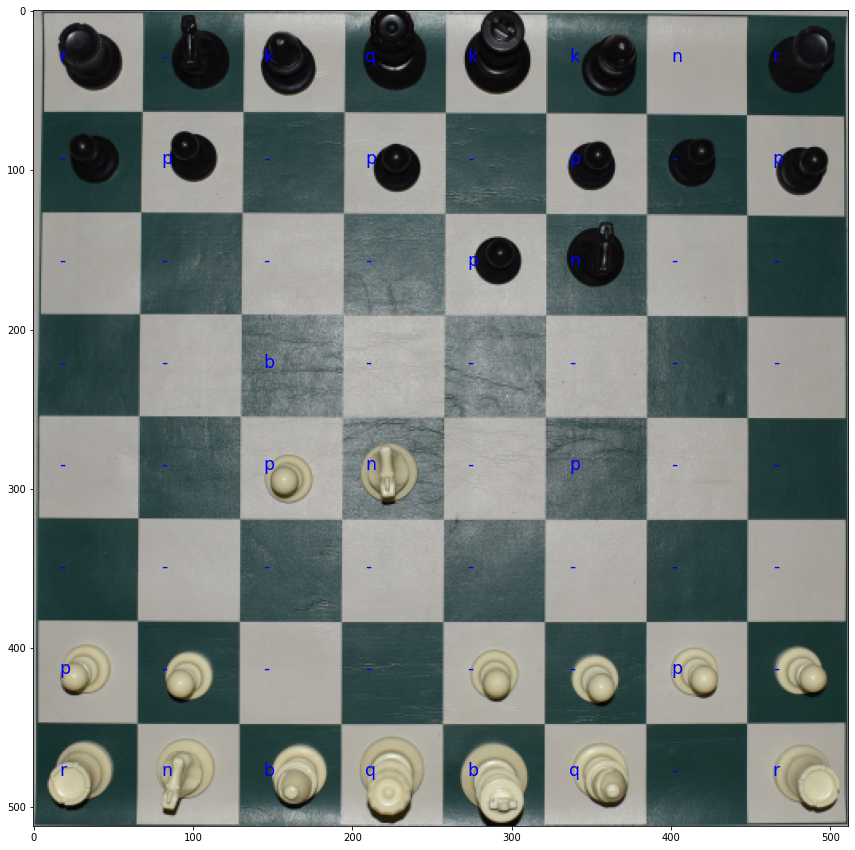

In [18]:
plt.figure(figsize=(15, 15))
for i in range(8):
  for j in range(8):
    p = class_pred[0, j * 8 + i]
    color = 'blue'
    plt.text((i + 0.25) * (INPUT_SIZE // 8), (j + 0.5) * (INPUT_SIZE // 8), p, color=color, size='xx-large')
plt.imshow(cropped)